Importiamo le librerie e il dataset MNIST messo a disposizione da Tensorflow

In [ ]:

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import numpy as np
import time


# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [15]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [17]:
tf.reset_default_graph()

# START PARAMETRI DA MODIFICARE 
learning_rate = 0.01
training_iters = 2000
# END PARAMETRI DA MODIFICARE 


batch_size = 128
display_step = 10

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input], name="placeholder_x")
y = tf.placeholder(tf.float32, [None, n_classes], name="placeholder_y")
keep_prob = tf.placeholder(tf.float32, name="placeholder_dropout") #dropout (keep probability)
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
argmax = tf.argmax(pred, 1) 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [18]:
start = time.time()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                      y: mnist.test.labels[:256],
                                      keep_prob: 1.})
print "Time elapsed: "+ str( time.time()-start)

Iter 1280, Minibatch Loss= 9423.970703, Training Accuracy= 0.64844
Optimization Finished!
Testing Accuracy: 0.628906
Time elapsed: 11.5400600433


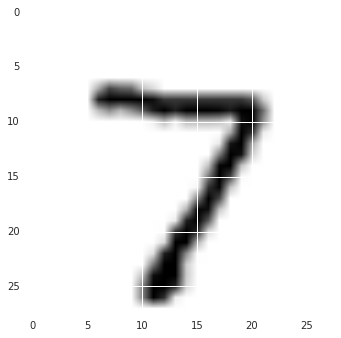

Number predicted is :  9


In [19]:
img = mnist.test.images[0]
with tf.Session() as sess:
  sess.run(init)
  
  classification = sess.run(argmax, feed_dict={x: [img],keep_prob: 1.})
  plt.imshow(img.reshape(28, 28), cmap=plt.cm.binary)
  plt.show()
  print 'Number predicted is : ', classification[0]